In [1]:
from dotenv import load_dotenv
import os
from qiskit import *
from qiskit_ibm_provider import IBMProvider
from math import *
import qiskit
from qiskit.circuit.library.standard_gates import *
from qiskit_ibm_provider import least_busy
load_dotenv()
IBM_KEY = os.getenv("API_KEY")
provider = IBMProvider()

## Boolean Function Quantum Implementation
Boolean functions aren't reversible but oracle functions are. Oracle Function can be defined for $F(x)$ as:
$$U_F(x_1, x_2, \cdots, x_n, b) = (x_1, x_2, \cdots, x_n, b \oplus F(x))$$
This oracle function is reversible and thus quantum gates which support reversible operations can be used to implement this.

In [2]:
def oracle():
    circ = QuantumCircuit(3)
    circ.ccx(0, 1, 2)
    return circ

## Deutsch-Jozsa Algorithm Implementation
- Extension of the Deutsch algorithm to n-bit Boolean functions

AIM: Find if the function $f(x)$ is balanced or constant given the promise that $f(x)$ is either constant or balanced. This algorithm can perform this classification in just a single query to the $U_f$ instead of the worst case $\frac{2^n}{2} + 1$ queries in the classical setting

Following is the implementation of the Deutsch-Jozsa Algorithm for $f(x) = x_2 \oplus x_3 \oplus x_4$

In [3]:
# Building an oracle function for f(x)
orcl = QuantumCircuit(5)
orcl.cx(1, 4)
orcl.cx(2, 4)
orcl.cx(3, 4)
oracle = orcl.to_instruction()
orcl.draw()

q_0: ───────────────
                    
q_1: ──■────────────
       │            
q_2: ──┼────■───────
       │    │       
q_3: ──┼────┼────■──
     ┌─┴─┐┌─┴─┐┌─┴─┐
q_4: ┤ X ├┤ X ├┤ X ├
     └───┘└───┘└───┘

In [4]:
# Quantum register, Classical register, Quantum Circuit creation
q = QuantumRegister(5)
c = ClassicalRegister(4)
qc = QuantumCircuit(q, c)

In [5]:
qc.x(4)
qc.h(range(5))
# Append the circuit of the oracle on the qubit register q to qc
qc.append(oracle, q)
qc.h(range(5))
for i in range(4):
    qc.measure(q[i], c[3 - i])

backend = Aer.get_backend('qasm_simulator')
qjob = execute(qc, backend, shots=1)
counts = qjob.result().get_counts()
print(counts)
# Output is not the state |0000>, implying f(x) is balanced

{'0111': 1}


## Bernstein-Vazirani Algorithm Implementation
AIM: Given the function $f(x)$ and given the promise that it is linear, i.e., $f(x) = a\cdot x$, the objective is to find $a$

The quantum circuit is same as that for the Deutsch-Jozsa algorithm.  
Following is the implementation of the Bernstein-Vazirani Algorithm for $f(x) = x_1 \oplus x_2 \oplus x_3 \oplus x_4$

In [6]:
# Building an oracle for the function
orcl = QuantumCircuit(5)
orcl.cx(0, 4)
orcl.cx(1, 4)
orcl.cx(2, 4)
orcl.cx(3, 4)
oracle = orcl.to_instruction()

In [7]:
# Creating a quauntum register, classical register and a quantum circuit

q = QuantumRegister(5)
c = ClassicalRegister(4)
qc = QuantumCircuit(q, c)

In [8]:
# Deutsch-Jozsa algorithm
qc.x(4)
qc.h(range(5))
qc.append(oracle, q)
qc.h(range(5))
for i in range(4):
    qc.measure(q[i], c[3 - i])

backend = Aer.get_backend('qasm_simulator')
qjob = execute(qc, backend, shots=1)
counts = qjob.result().get_counts()
print(counts)
# From the output, we can see a = 1111, i.e., f(x) is a linear function of the form f(x) = 1111.x

{'1111': 1}


### Computing Walsh Spectrum in a Classical Environment

In [9]:
# Consider the 4-bit boolean function, f(x) = x1.x2 xor x3 xor x4
def func(x):
    x_arr = [0]*4
    for i in range(4):
        x_arr[3 - i] = x % 2
        x = (x - x_arr[3 - i]) / 2
    return ((x_arr[0]*x_arr[1]) + x_arr[2] + x_arr[3]) % 2


# Function that outputs the dot product of bit strings x and y

def dot(x, y):
    x_arr = [0]*4
    y_arr = [0]*4
    dot = 0
    for i in range(4):
        x_arr[3 - i] = x % 2
        x = (x - x_arr[3 - i]) / 2
        y_arr[3 - i] = y % 2
        y = (y - y_arr[3 - i]) / 2
        dot = dot + (x_arr[3 - i]*y_arr[3 - i])
    return dot % 2

In [10]:
# Calculating Walsh coeffs of the above function for all points
w_f = [0]*16
for y in range (16):
    for x in range (16):
        w_f[y] = w_f[y] + ((-1)** func(x))*(( -1)**dot(x, y))


for i in range (16):
    print(bin(i)[2:]. zfill (4), ":", w_f[i])

0000 : 0.0
0001 : 0.0
0010 : 0.0
0011 : 8.0
0100 : 0.0
0101 : 0.0
0110 : 0.0
0111 : 8.0
1000 : 0.0
1001 : 0.0
1010 : 0.0
1011 : 8.0
1100 : 0.0
1101 : 0.0
1110 : 0.0
1111 : -8.0


From the above, we can infer that the square of the normalized Walsh coefficient at points y $\in \{0011, 0111, 1011, 1111\}$ is $\frac{64}{256}=0.25$

In [11]:
# Deutsch-Jozsa algorithm for estimating the Walsh Spectrum of the function f(x)

# Orale function for f(x) = x1x2 xor x3 xor x4
orcl = QuantumCircuit(5)
orcl.ccx(0, 1, 4)
orcl.cx(3, 4)
oracle = orcl.to_instruction()

q = QuantumRegister(5)
c = ClassicalRegister(4)
qc = QuantumCircuit(q, c)

# Implementing Deutsch-Jozsa algorithm
qc.x(q[4])
for i in range(5):
    qc.h(q[i])
qc.append(oracle, q)
for i in range(5):
    qc.h(q[i])
for i in range(4):
    qc.measure(q[3 - i], c[i])


# Executing backend in simulator
backend = Aer.get_backend('qasm_simulator')
qjob_sim_100 = execute(qc, backend, shots=100)
counts_sim_100 = qjob_sim_100.result().get_counts()
qjob_sim_1000 = execute(qc, backend, shots=1000)
counts_sim_1000 = qjob_sim_1000.result().get_counts()
qjob_sim_8000 = execute(qc, backend, shots=8000)
counts_sim_8000 = qjob_sim_8000.result().get_counts()

for count1, count2, count3 in zip(counts_sim_100, counts_sim_1000, counts_sim_8000):
    counts_sim_100[count1] /= 100
    counts_sim_1000[count2] /= 1000
    counts_sim_8000[count3] /= 8000

print("Estimate of Walsh spectrum using 100 shots: \n", counts_sim_100, "\n")
print("Estimate of Walsh spectrum using 1000 shots: \n", counts_sim_1000, "\n")
print("Estimate of Walsh spectrum using 8000 shots: \n", counts_sim_8000, "\n")
# For points not in the returned set of values, those should be inferred as 0

Estimate of Walsh spectrum using 100 shots: 
 {'0101': 0.26, '1101': 0.27, '1001': 0.26, '0001': 0.21} 

Estimate of Walsh spectrum using 1000 shots: 
 {'1101': 0.263, '0001': 0.252, '1001': 0.23, '0101': 0.255} 

Estimate of Walsh spectrum using 8000 shots: 
 {'0001': 0.249125, '1001': 0.248, '1101': 0.254, '0101': 0.248875} 



Shots = 100 is a very rough estimate, as we get values like 0.28, 0.23 etc. Estimates using 1000 and 8000 are better, 8000 faring the best  
Now, implementing the circuit on an actual quantum computer, 5bit qubit ibmq_belem

In [12]:
provider.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('ibm_perth')>]

In [31]:
backend = provider.get_backend('ibmq_belem')
backend.status().to_dict()


{'backend_name': 'ibmq_belem',
 'backend_version': '',
 'operational': True,
 'pending_jobs': 39,
 'status_msg': 'active'}

In [32]:
# executing ckt on ibmxq2
qjob_real = execute(qc, backend, shots=1000)
counts_real = qjob_real.result().get_counts()
for count in counts_real:
    counts_real[count] /= 1000

print("Estimate of Walsh spectrum using 100 shots: \n", counts_real, "\n")

Estimate of Walsh spectrum using 100 shots: 
 {'0000': 0.035, '0001': 0.235, '0010': 0.001, '0011': 0.005, '0100': 0.022, '0101': 0.167, '0111': 0.002, '1000': 0.028, '1001': 0.226, '1010': 0.002, '1011': 0.002, '1100': 0.022, '1101': 0.249, '1111': 0.004} 



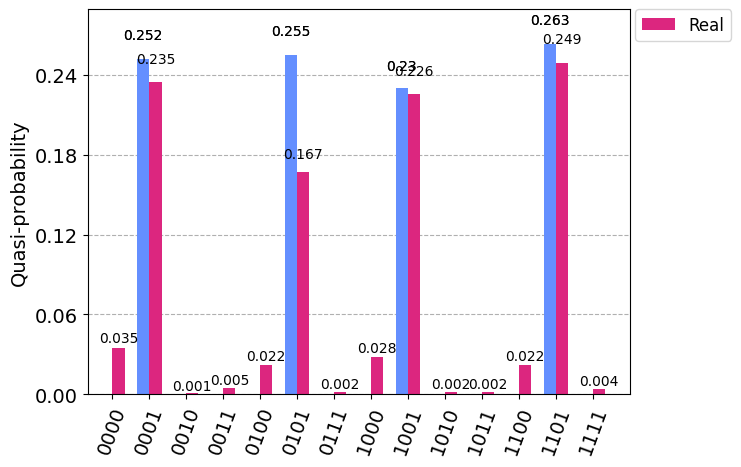

In [24]:
from qiskit.tools.visualization import plot_histogram
plot_histogram([counts_sim_1000, counts_real], legend =["Simulator", "Real"])

These errors are mostly attributed to the de-coherence of the quantum system and the undesired interactions with the environment